In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler # normalization
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

In [2]:
df = pd.read_csv("dataset/tennis_players.csv", skipinitialspace=True, sep=',', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 3885
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   2072 non-null   object 
 1   ratio                  2072 non-null   float64
 2   num_matches_2016-2019  2072 non-null   float64
 3   ratio_2016-2019        2072 non-null   float64
 4   num_matches_2020-2021  2072 non-null   float64
 5   ratio_2020-2021        2072 non-null   float64
 6   hand                   2072 non-null   object 
 7   gender                 2072 non-null   object 
 8   ioc                    2072 non-null   object 
 9   birth                  2072 non-null   float64
 10  ht                     2072 non-null   float64
 11  minutes                2072 non-null   float64
 12  perc_ace               2072 non-null   float64
 13  serv_won_tot_seve      2072 non-null   float64
 14  bpFaced                2072 non-null   float64
 15  perc

### Drop categorical data

In [3]:
del df['name']
del df['hand']
del df['gender']
del df['ioc']

### Drop most correlated attributes

In [4]:
corr_threshold = 0.9
print("Att. A\tAtt. B\tCorr(A,B)")
for i in range(0, len(df.columns)):
    for j in range(i+1, len(df.columns)):
        corr = df[df.columns[i]].corr(df[df.columns[j]])
        if  corr > corr_threshold:
            print(df.columns[i] + "\t" + df.columns[j] + "\t" + '{:.4f}'.format(corr))

Att. A	Att. B	Corr(A,B)
num_matches_2016-2019	bpFaced	0.9253
serv_won_tot_seve	perc_2ndwon	0.9248


In [5]:
del df['num_matches_2016-2019'] #PERCHE'?
del df['bpFaced']
del df['serv_won_tot_seve']
del df['perc_2ndwon']

In [6]:
df.head()

,ratio,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,birth,ht,minutes,perc_ace,perc_df,perc_v_ace,perc_v_df,perc_v_1stwon
0,0.181818,0.200000,1.0,0.000000,1996.0,187.076923,86.694444,14.98,12.32,8.82,5.88,75.79
1,0.477707,0.478873,15.0,0.466667,1994.0,170.857143,61.621951,1.30,4.67,3.18,5.39,39.67
2,0.500000,0.461538,3.0,0.666667,1998.0,183.800000,86.875000,20.59,10.89,7.12,10.10,70.86
4,0.588710,0.576577,13.0,0.692308,1992.0,172.137193,62.577626,3.37,11.18,3.83,7.73,52.62
5,0.153846,0.153846,0.0,0.000000,1995.0,172.137193,59.409091,0.00,16.30,0.51,2.55,11.88


### MinMax Normalization before clustering

In [7]:
scaler = MinMaxScaler()
df_norm_minmax = scaler.fit_transform(df.values)
#print(df_norm_minmax)

### ZScore Normalization before clustering

In [8]:
scaler = StandardScaler()
#print( scaler.fit(df.head().values) )
#print( df.head().values )
#print( scaler.transform(df.head().values) )
df_norm_zscore = scaler.fit_transform(df.values) # e non df.head()
#scaler.inverse_transform(scaler.transform(df.head().values))

### Partitional and center-based clustering: K-Means

**Objective:** Clusters the data into $k$ groups.
* **Init step:** Select k points at random as cluster centers.
* **Assignment step:** Assign each instance to the cluster with the closest mean according to the distance function.
* **Update step**: Calculate the new means to be the centroids of the instances in the new clusters.
* ***Repeat*** steps 2 and 3 until the assignment no longer change.

There is no guarantee that the optimum is found using this algorithm.

## Problems

* Initial Centroids
* Number of clusters

### Number of clusters decision: Elbow Method on the clusters Inertia
In cluster analysis, the elbow method is a heuristic used in determining the optimal number of clusters in a data set. 
<br>It consists of plotting the SSE as a function of the number of clusters, and **picking the elbow** of the curve as the *k* to use.

We start from an initial value of 2 and we keep computing the clusterization until we reach the value of 30, our choice for the maximum value of *k*. 
<br>Considering ranges of k differing in size may lead to slightly different elbows, so we also plot the curves of the intervals [2,10] and [2,20].


Average Silhouette Method
The silhouette score is an indicator of both separation and cohesion among clusters. Here we look for the clusterization with the highest average silhouette score among those computed by K-means.

Calinski Harabasz Method

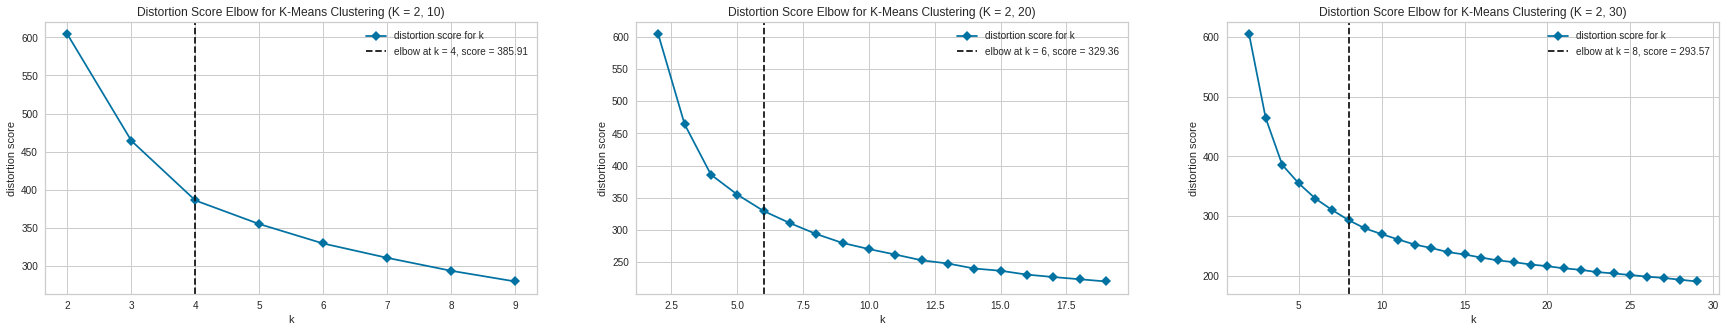

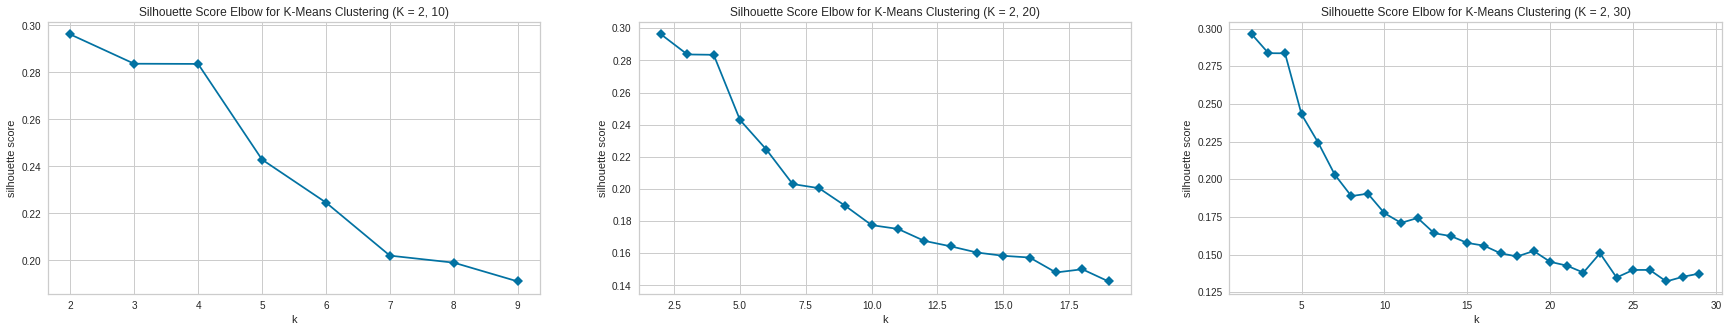

An analysis of the average Silhouette score highlights a global maxima for k equals to 2 and a local maxima for k equals to 3 or 4
We add these values to the list of candidates for the optimal value of k.


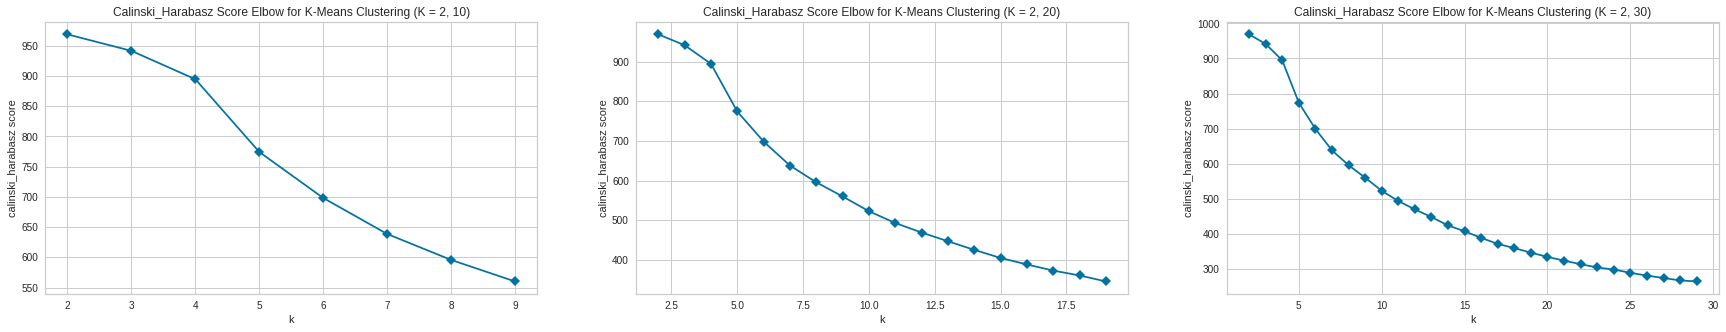

In [9]:
df_norm = df_norm_minmax # can try both the normalized forms without obtaining differences
#df_norm = df_norm_zscore

k_start = [2]
k_max = [10, 20, 30]
Ks = []
model = KMeans()

f, axs = plt.subplots(nrows=1, ncols=len(k_max), figsize=(30,5)) # print the elbow plots
for i in range(len(k_max)):
    vis = KElbowVisualizer(model, k=(k_start[0],k_max[i]), metric='distortion', timings=False, ax=axs[i])
    vis.fit(df_norm)  
    axs[i].set_title('Distortion Score Elbow for K-Means Clustering (K = ' + str(k_start[0]) + ', ' + str(k_max[i]) + ')' )
    axs[i].set_ylabel('distortion score')
    axs[i].set_xlabel('k')
    axs[i].legend(['distortion score for k','elbow at k = ' + str(vis.elbow_value_) + ', score = ' + '{:.2f}'.format(vis.elbow_score_)])
    if (vis.elbow_value_ not in Ks) and (vis.elbow_value_ != None):
        Ks.append(vis.elbow_value_)
plt.show()


k_start = [2]
k_max = [10, 20, 30]
model = KMeans()

f, axs = plt.subplots(nrows=1, ncols=len(k_max), figsize=(30,5))
for i in range(len(k_max)):
    vis = KElbowVisualizer(model, k=(k_start[0],k_max[i]), metric='silhouette', timings=False, ax=axs[i], locate_elbow=False)
    vis.fit(df_norm)  
    axs[i].set_title('Silhouette Score Elbow for K-Means Clustering (K = ' + str(k_start[0]) + ', ' + str(k_max[i]) + ')' )
    axs[i].set_ylabel('silhouette score')
    axs[i].set_xlabel('k')
plt.show()
print("An analysis of the average Silhouette score highlights a global maxima for k equals to 2 and a local maxima for k equals to 3 or 4")
print("We add these values to the list of candidates for the optimal value of k.")

k_start = [2]
k_max = [10, 20, 30]
model = KMeans()

f, axs = plt.subplots(nrows=1, ncols=len(k_max), figsize=(30,5))
for i in range(len(k_max)):
    vis = KElbowVisualizer(model, k=(k_start[0],k_max[i]), metric='calinski_harabasz', timings=False, ax=axs[i], locate_elbow=False)
    vis.fit(df_norm)  
    axs[i].set_title('Calinski_Harabasz Score Elbow for K-Means Clustering (K = ' + str(k_start[0]) + ', ' + str(k_max[i]) + ')' )
    axs[i].set_ylabel('calinski_harabasz score')
    axs[i].set_xlabel('k')
plt.show()

### Visualization of the clusters in 2 dimensions

Parameters:
* **n_clusters**: The number of clusters
* **n_init**: Number of time k-means will be run with different initial centroids. The final results will be the best output in terms of inertia.
* **max_iter**: Maximum number of iterations of the k-means algorithm for a single run.

Output:
* **labels_**: Labels of each point
* **cluster\_centers_**: Coordinates of cluster centers
* **inertia_**: Sum of squared distances of samples to their closest cluster center.

KMeans()
{0: 245, 1: 267, 2: 302, 3: 167, 4: 322, 5: 204, 6: 268, 7: 297}


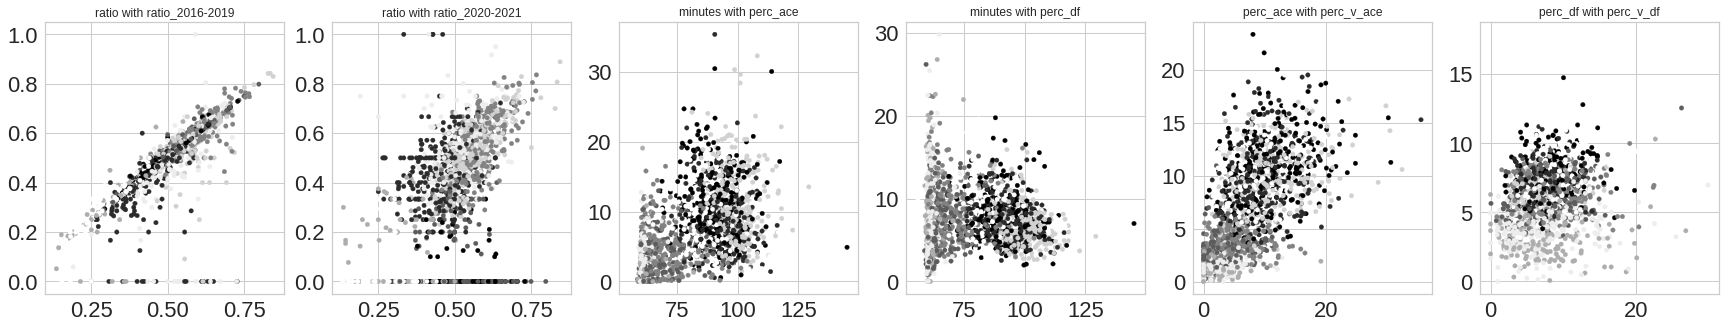

KMeans(max_iter=100, n_clusters=2)
{0: 1147, 1: 925}


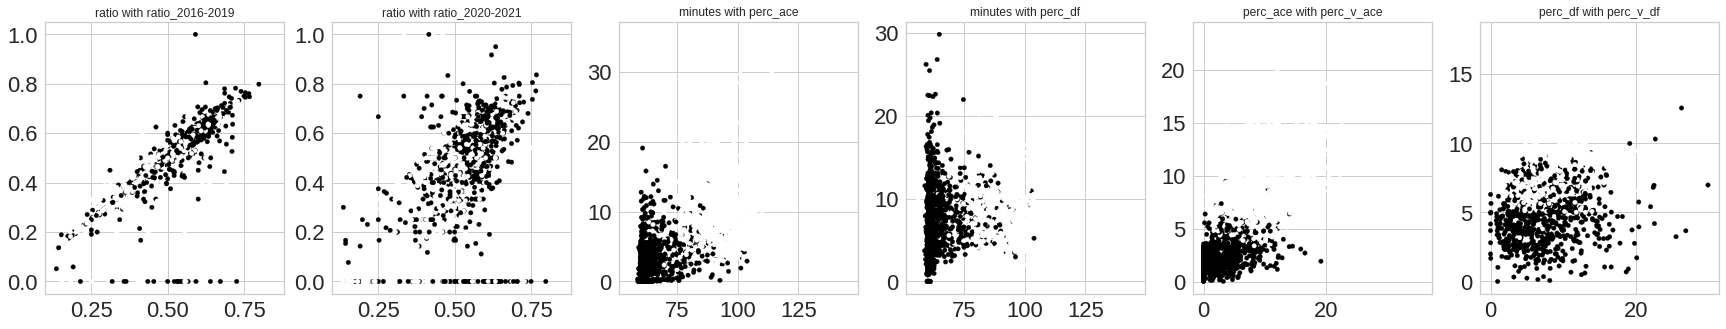

KMeans(max_iter=100, n_clusters=3)
{0: 585, 1: 715, 2: 772}


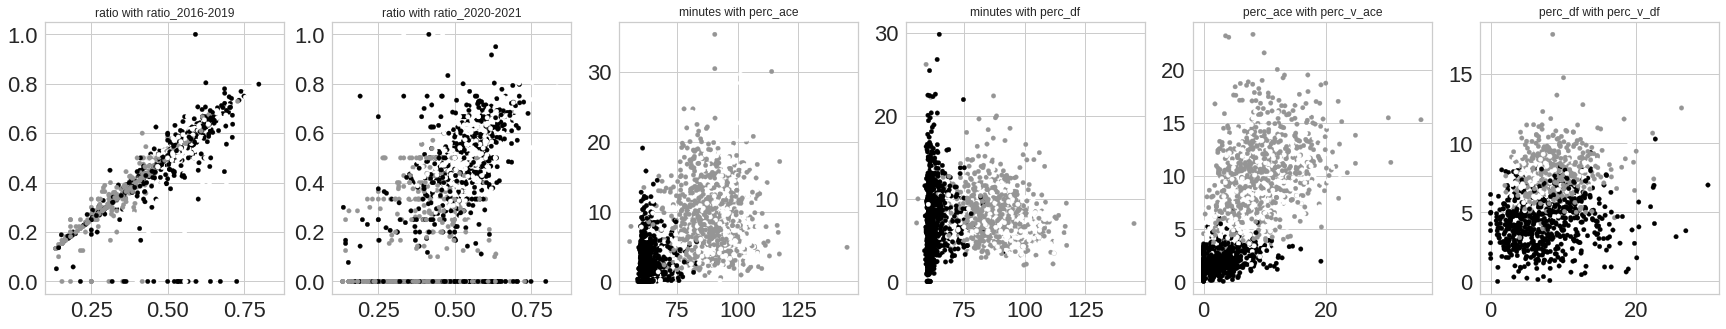

KMeans(max_iter=100, n_clusters=4)
{0: 661, 1: 535, 2: 522, 3: 354}


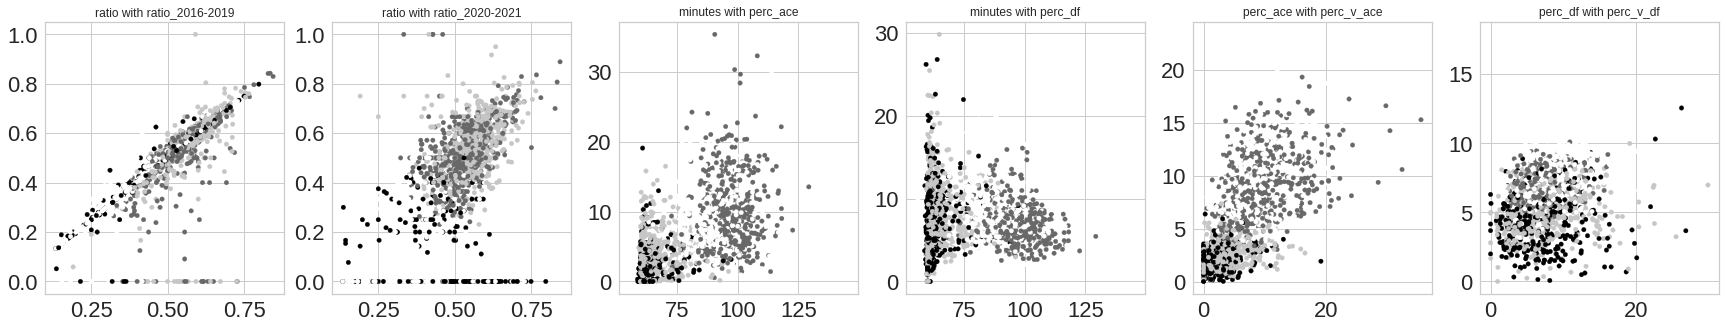

In [10]:
df_norm = df_norm_minmax # can try both the normalized forms without obtaining differences
#df_norm = df_norm_zscore

for i in range(1,5):
    if i==1:
        kmeans = KMeans(n_clusters=8, n_init=10, max_iter=300) #default parameters
    else:
        kmeans = KMeans(n_clusters=i, n_init=10, max_iter=100) #global max k=2, local max k=3,4 from the Silhouette score analyisis

    print(kmeans.fit(df_norm)) 
    #print( kmeans.labels_[:5] ) #labels
    #print( np.unique(kmeans.labels_, return_counts=True) ) # observing the size of each cluster
    hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
    print( dict(zip(bins, hist)) )
        
    f, axs = plt.subplots(ncols=6, figsize=(30,5))
    for j in range(0,6):
        if j==0:
            df1,df2 = df['ratio'],df['ratio_2016-2019']
        elif j==1:
            df1,df2 = df['ratio'],df['ratio_2020-2021']
        elif j==2:
            df1,df2 = df['minutes'],df['perc_ace']
        elif j==3:
            df1,df2 = df['minutes'],df['perc_df']
        elif j==4:
            df1,df2 = df['perc_ace'],df['perc_v_ace']
        elif j==5:
            df1,df2 = df['perc_df'],df['perc_v_df']


        axs[j].scatter(df1, df2, c=kmeans.labels_, s=20)
        axs[j].tick_params(axis='both', which='major', labelsize=22)
        axs[j].set_title(df1.name+" with "+df2.name)

    plt.show()